### Importação das Bibliotecas

In [1]:
# Tratamento dos dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

# Ciência de Dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Biblioteca do Prophet - Modelo de Projeção
from prophet import Prophet
from prophet.plot import plot, plot_plotly, plot_components_plotly, add_changepoints_to_plot
from prophet.plot import add_changepoints_to_plot, plot_seasonality, plot_cross_validation_metric
from prophet.diagnostics import cross_validation

### Importação e Descrição dos Dados

Essa é a parte 3 de um projeto que busca prever as vendas de uma padaria francesa, agora através de modelos de Deep Learning.

Para uma melhor compreensão do cenário, caso ainda não tenha acompanhado, recomenda-se ler o notebook ```bakery_sales_data_analysis.ipynb``` que apresenta uma analise exploratória do dados e o notebook ```bakery_sales_forecasting.ipynb``` traz previsões de vendas com modelos de regressão de Machine Learning.

In [2]:
df = pd.read_csv('bakery_sales.csv', index_col=0)

# Update datatypes and data processing
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M').dt.time

df['Quantity'] = df['Quantity'].apply(lambda x: abs(int(x)))
df['Quantity'] = df['Quantity'].astype(int)

df['unit_price'] = df['unit_price'].str[:-2]
df['unit_price'] = df['unit_price'].str.replace(",",".")
df['unit_price'] = df['unit_price'].astype(float)

df['ticket_number'] = df['ticket_number'].astype(int)

# Cria coluna do total da compra
df['total_bill'] = df['Quantity'] * df['unit_price']

# Como nesse momento não será feita uma análise por produto, a coluna sera dropada
df.rename(columns={'Quantity':'quantity'}, inplace=True)
df_backup = df.copy()
df.drop(columns=['article', 'unit_price'], inplace=True)
df.head()

,date,time,ticket_number,quantity,total_bill
0,2021-01-02,08:38:00,150040,1,0.90
1,2021-01-02,08:38:00,150040,3,3.60
4,2021-01-02,09:14:00,150041,2,2.40
5,2021-01-02,09:14:00,150041,1,1.15
8,2021-01-02,09:25:00,150042,5,6.00


In [3]:
# Agrupa os dados por ticket (nota fiscal)
df_grouped = df.groupby(by=('ticket_number')).agg({'date':'first',
                                                   'time':'first',
                                                   'quantity':'sum',
                                                   'total_bill':'sum'})

df_grouped.reset_index(inplace=True)

df_grouped.head()

,ticket_number,date,time,quantity,total_bill
0,150040,2021-01-02,08:38:00,4,4.50
1,150041,2021-01-02,09:14:00,3,3.55
2,150042,2021-01-02,09:25:00,5,6.00
3,150043,2021-01-02,09:25:00,5,5.10
4,150044,2021-01-02,09:27:00,1,1.05


In [4]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136451 entries, 0 to 136450
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ticket_number  136451 non-null  int32         
 1   date           136451 non-null  datetime64[ns]
 2   time           136451 non-null  object        
 3   quantity       136451 non-null  int32         
 4   total_bill     136451 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ MB


#### Novas Features

In [7]:
# Novas Variaves, para analise
df = df_grouped.copy()

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['day_week'] = df.date.dt.day_of_week
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# Cria um dataset com dados diarios
df_daily = df_grouped[['date', 'quantity', 'total_bill']].groupby('date').sum().reset_index()

df_daily['year'] = df_daily.date.dt.year
df_daily['month'] = df_daily.date.dt.month
df_daily['day'] = df_daily.date.dt.day
df_daily['day_week'] = df_daily.date.dt.day_of_week
df_daily['day_of_year'] = df_daily.date.dt.dayofyear

df_daily.rename(columns={'total_bill':'sales'}, inplace=True)
df_daily.head()

,date,quantity,sales,year,month,day,day_week,day_of_year
0,2021-01-02,581,987.85,2021,1,2,5,2
1,2021-01-03,566,1016.10,2021,1,3,6,3
2,2021-01-04,315,461.90,2021,1,4,0,4
3,2021-01-05,315,536.50,2021,1,5,1,5
4,2021-01-07,310,544.00,2021,1,7,3,7


In [9]:
df_daily.shape

(600, 8)

## Previsão com Deep Learning

### Organizando os dados

⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️ Inserir descrição

In [17]:
df = df_daily[['year', 'day_of_year', 'sales']]
df.head()

,year,day_of_year,sales
0,2021,2,987.85
1,2021,3,1016.10
2,2021,4,461.90
3,2021,5,536.50
4,2021,7,544.00


In [20]:
# Cria uma coluna de valor numérico que representa a evolução dos dias
day_value = 1/365
df.loc[:,'date'] = df['year'] + df['day_of_year']*day_value
df = df[['date', 'sales']]
df.head()

,date,sales
0,2021.005479,987.85
1,2021.008219,1016.10
2,2021.010959,461.90
3,2021.013699,536.50
4,2021.019178,544.00


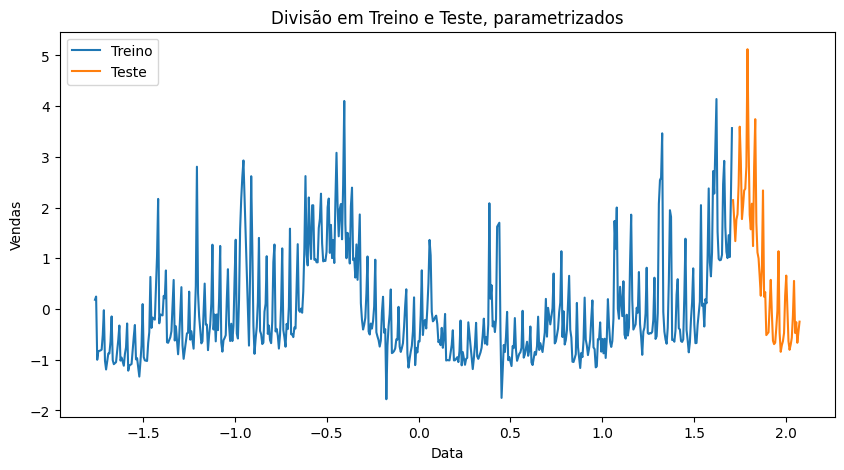

In [80]:
# Divisão dos dados em treino e teste
len_train = len(df)*0.90
len_test = len(df)-len_train

train_data = df.loc[:len_train]
test_data = df.loc[len_train+1:]

# Aplica scaler
scaler = StandardScaler()
scaler.fit(train_data)
train_data_sc = scaler.transform(train_data)
test_data_sc = scaler.transform(test_data)

train_data_sc = pd.DataFrame(train_data_sc, columns=train_data.columns)
test_data_sc = pd.DataFrame(test_data_sc, columns=train_data.columns)

# Continua na divisão dos dados
X_train = train_data_sc['date']
y_train = train_data_sc['sales']

X_test = test_data_sc['date']
y_test = test_data_sc['sales']

# Plota dados de divisão
plt.figure(figsize=(10,5))
sns.lineplot(x=X_train, y=y_train, label='Treino') 
sns.lineplot(x=X_test, y=y_test,label='Teste')
plt.title('Divisão em Treino e Teste, parametrizados')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

### Criando o modelo

In [81]:
from keras.models import Sequential
from keras.layers import Dense

#### Regressão Linear com Keras

In [111]:
model = Sequential()

model.add(Dense(1, input_dim=1, kernel_initializer='Ones', activation='linear', use_bias=False))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 1)              │             1 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1 (4.00 B)

 Trainable params: 1 (4.00 B)

 Non-trainable params: 0 (0.00 B)

In [112]:
model.fit(X_train, y_train)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8045   


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<Axes: xlabel='date', ylabel='sales'>

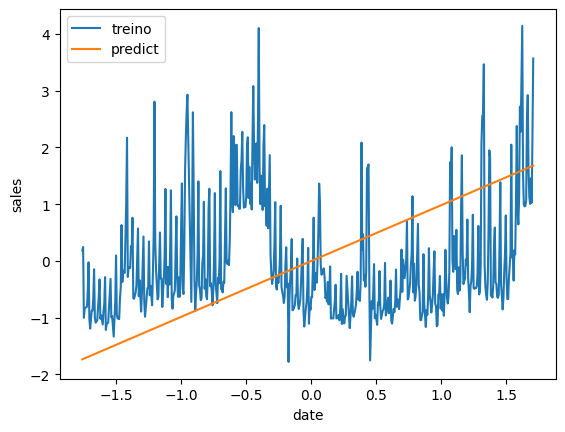

In [113]:
y_predict = model.predict(X_train)

sns.lineplot(x=X_train, y=y_train, label='treino')
sns.lineplot(x=X_train, y=y_predict[:,0], label='predict')

In [117]:
# Organiza os resultados num dataframe
resultados = pd.DataFrame(data={'date':X_train, 'sales':y_train})
# Volta os resultados para a escala original
resultados_orig = scaler.inverse_transform(resultados)
resultados_orig = pd.DataFrame(resultados_orig, columns=resultados.columns)
resultados_orig.head()

,date,sales
0,2021.005479,987.85
1,2021.008219,1016.10
2,2021.010959,461.90
3,2021.013699,536.50
4,2021.019178,544.00


#### V2 - 

Ver sobre o kernet_initializer padrão

In [134]:
model2 = Sequential()

model2.add(Dense(8, input_dim=1, activation='relu'))

model2.add(Dense(8, activation='relu'))

model2.add(Dense(1, activation='relu'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.summary()

c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [135]:
model2.fit(X_train, y_train, epochs=200)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2090
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2408 
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1870 
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0842 
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0734  
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0470 
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0196 
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0260 
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9899 
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9838 
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0664 
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0619 
Epoch 13/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0658 
Epoch 14/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0036 
Epoch 15/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<Axes: xlabel='date', ylabel='sales'>

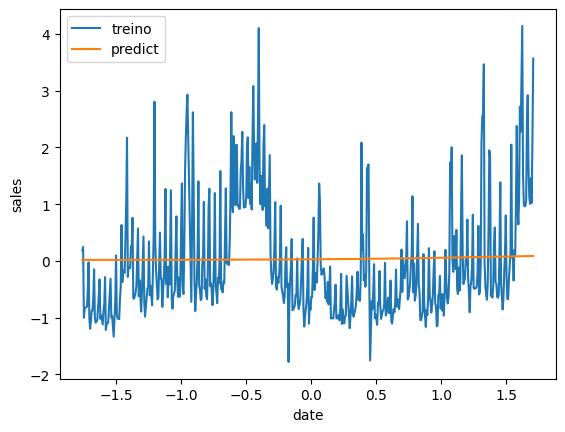

In [136]:
y_predict2 = model2.predict(X_train)

sns.lineplot(x=X_train, y=y_train, label='treino')
sns.lineplot(x=X_train, y=y_predict2[:,0], label='predict')

In [ ]:
# Organiza os resultados num dataframe
resultados = pd.DataFrame(data={'date':X_train, 'sales':y_train})
# Volta os resultados para a escala original
resultados_orig = scaler.inverse_transform(resultados)
resultados_orig = pd.DataFrame(resultados_orig, columns=resultados.columns)
resultados_orig.head()

#### V3 - Utilizando lags

Agora com ideia de lags, onde xtrain e ytrain são os valores de vendas

In [151]:
# Novos dados de treino
X_train_n = y_train[:-1]
y_train_n = y_train[1:]

#Novos dados de teste
X_test_n = y_test[:-1]
y_test_n = y_test[1:]

In [192]:
model3 = Sequential()
model3.add(Dense(8, input_dim=1,  activation='linear'))
model3.add(Dense(64,  activation='sigmoid'))
model3.add(Dense(1,  activation='linear'))
model3.compile(loss='mean_squared_error',optimizer='adam')
model3.summary()

c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [193]:
model3.fit(X_train_n, y_train_n, epochs=200)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4043
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4659 
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9996 
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9135 
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8897 
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7364 
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6404 
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6846 
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5164 
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5156 
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5457 
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5220 
Epoch 13/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5296 
Epoch 14/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5053 
Epoch 15/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


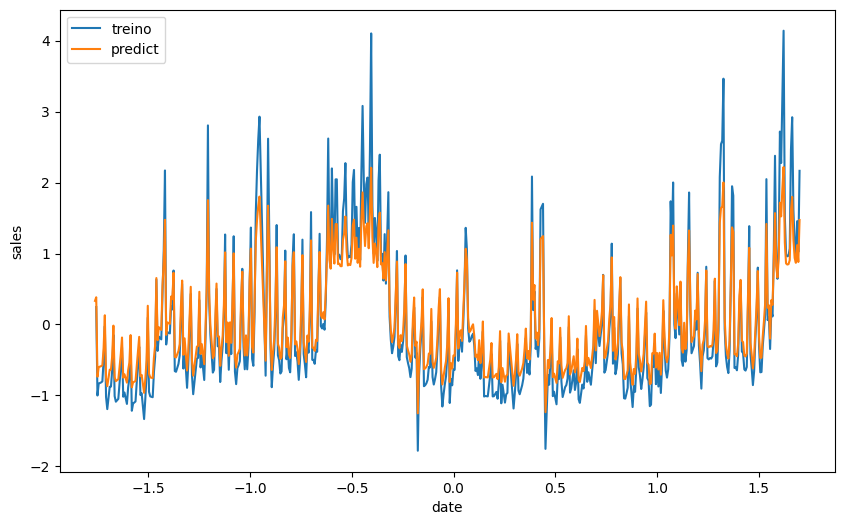

In [194]:
y_predict3 = model3.predict(X_train_n)

plt.figure(figsize=(10,6))
sns.lineplot(x=X_train[:-1], y=y_train_n, label='treino')
sns.lineplot(x=X_train[:-1], y=y_predict3[:,0], label='predict')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


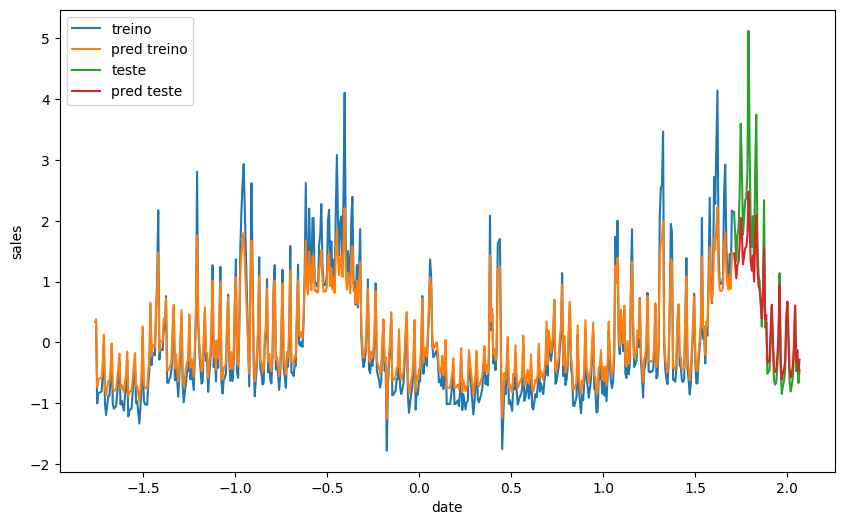

In [199]:
y_test_pred3 = model3.predict(X_test_n)

plt.figure(figsize=(10,6))
sns.lineplot(x=X_train[:-1], y=y_train_n, label='treino')
sns.lineplot(x=X_train[:-1], y=y_predict3[:,0], label='pred treino')

sns.lineplot(x=X_test[:-1], y=y_test, label='teste')
sns.lineplot(x=X_test[:-1], y=y_test_pred3[:,0], label='pred teste')
plt.show()

FAzer previsão com mais de um dia.

Fazer test PACF de quantas lags seria interessante inserir no modelo